In [1]:
!pip install mediapipe opencv-python

In [2]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Processing Videos Using MediaPipe


In [3]:
#relevant imports
import mediapipe as mp
import cv2
import pandas as pd
import os
import numpy as np


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [4]:
#loading all the files
base_dir = '/content/drive/MyDrive/CS496_Health_Sensing/Activities'
video_files = []
for base, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith('.mp4') or file.endswith('.MOV'):
            full_path = os.path.join(base, file)
            video_files.append(full_path)


In [5]:
mp_pose = mp.solutions.pose
#can play around with the hyperparameters below
pose = mp_pose.Pose(static_image_mode=False, model_complexity=2, enable_segmentation=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)


complete_pose_data = []

videos_processed = 0

for video_file in video_files:
  videos_processed += 1
  print(f'processing video {videos_processed}/{len(video_files)}: {video_file}')

  activity = os.path.basename(os.path.dirname(video_file))
  vid = cv2.VideoCapture(video_file)

  per_video_frame_data = []
  frame_num = 0

  while vid.isOpened():
    sucsess, frame = vid.read()
    if not sucsess: #migh be unabel to read the video
      break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) #had to change this since cv2 reads it in BGR order
    #https://www.geeksforgeeks.org/python/python-opencv-cv2-cvtcolor-method/

    results = pose.process(rgb)

    if results.pose_landmarks:
      for i, kp in enumerate(results.pose_landmarks.landmark):
        per_video_frame_data.append({
            'activity': activity,
            'video_file': video_file,
            'frame': frame_num,
            'kp_idx': i,
            'x': kp.x,
            'y': kp.y,
            'z': kp.z,
            'visibility': kp.visibility
        })

    frame_num += 1
  vid.release()
  complete_pose_data.extend(per_video_frame_data)

pose.close()
raw_pose_data_df = pd.DataFrame(complete_pose_data)
print(raw_pose_data_df.head())
print(raw_pose_data_df.info())





processing video 1/80: /content/drive/MyDrive/CS496_Health_Sensing/Activities/Lunge/lunge_0.MOV
processing video 2/80: /content/drive/MyDrive/CS496_Health_Sensing/Activities/Lunge/lunge_1.MOV
processing video 3/80: /content/drive/MyDrive/CS496_Health_Sensing/Activities/Lunge/lunge_2.MOV
processing video 4/80: /content/drive/MyDrive/CS496_Health_Sensing/Activities/Lunge/lunge_3.MOV
processing video 5/80: /content/drive/MyDrive/CS496_Health_Sensing/Activities/Lunge/lunge_4.MOV
processing video 6/80: /content/drive/MyDrive/CS496_Health_Sensing/Activities/Lunge/lunge_5.MOV
processing video 7/80: /content/drive/MyDrive/CS496_Health_Sensing/Activities/Lunge/lunge_6.MOV
processing video 8/80: /content/drive/MyDrive/CS496_Health_Sensing/Activities/Lunge/lunge_7.MOV
processing video 9/80: /content/drive/MyDrive/CS496_Health_Sensing/Activities/Lunge/lunge_8.MOV
processing video 10/80: /content/drive/MyDrive/CS496_Health_Sensing/Activities/Lunge/lunge_9.MOV
processing video 11/80: /content/drive/

Calculate Joint Angles


In [6]:
def calculate_angles_from_kp(kp1, kp2, kp3):
  kp1 = np.array(kp1)
  kp2 = np.array(kp2)
  kp3 = np.array(kp3)

  vec1 = kp2 - kp1
  vec2 = kp3 - kp2

  dot = np.dot(vec1, vec2)
  norm1 = np.linalg.norm(vec1)
  norm2 = np.linalg.norm(vec2)

  if norm1 == 0 or norm2 == 0:
    return 0.0

  cosine_ang = dot / (norm1 * norm2)
  cosine_ang = np.clip(cosine_ang, -1.0, 1.0)
  angle = np.arccos(cosine_ang)
  return np.degrees(angle)


Get the joints/kps of interest

In [7]:
def get_coordinates(landmarks, kp_idx):
  coords = landmarks[landmarks['kp_idx'] == kp_idx]
  if not coords.empty:
    return [coords['x'].iloc[0], coords['y'].iloc[0], coords['z'].iloc[0]]

Create Dataframe of Joint Angles

In [8]:
import numpy as np

In [9]:
#calculated using info from complete pose data organized
pose_organized = raw_pose_data_df.groupby(['activity', 'video_file', 'frame'])
complete_angle_data = []

for (activity, video_file, frame), group in pose_organized:
  row = {
      'activity': activity,
      'video_file': video_file,
      'frame': frame
  }

  #Left Arm
  l_shoulder = get_coordinates(group, mp_pose.PoseLandmark.LEFT_SHOULDER.value)
  l_elbow = get_coordinates(group, mp_pose.PoseLandmark.LEFT_ELBOW.value)
  l_wrist = get_coordinates(group, mp_pose.PoseLandmark.LEFT_WRIST.value)

  if l_shoulder and l_elbow and l_wrist:
    row['left_elbow_angle'] = calculate_angles_from_kp(l_shoulder, l_elbow, l_wrist)
  else:
    row['left_elbow_angle'] = np.nan

  # Right Arm
  r_shoulder = get_coordinates(group, mp_pose.PoseLandmark.RIGHT_SHOULDER.value)
  r_elbow = get_coordinates(group, mp_pose.PoseLandmark.RIGHT_ELBOW.value)
  r_wrist = get_coordinates(group, mp_pose.PoseLandmark.RIGHT_WRIST.value)

  if r_shoulder and r_elbow and r_wrist:
    row['right_elbow_angle'] = calculate_angles_from_kp(r_shoulder, r_elbow, r_wrist)
  else:
    row['right_elbow_angle'] = np.nan

  # Left Leg
  l_hip = get_coordinates(group, mp_pose.PoseLandmark.LEFT_HIP.value)
  l_knee = get_coordinates(group, mp_pose.PoseLandmark.LEFT_KNEE.value)
  l_ankle = get_coordinates(group, mp_pose.PoseLandmark.LEFT_ANKLE.value)

  if l_hip and l_knee and l_ankle:
    row['left_knee_angle'] = calculate_angles_from_kp(l_hip, l_knee, l_ankle)
  else:
    row['left_knee_angle'] = np.nan

  if l_shoulder and l_hip and l_knee:
    row['left_hip_angle'] = calculate_angles_from_kp(l_shoulder, l_hip, l_knee)
  else:
    row['left_hip_angle'] = np.nan

  # Right Leg
  r_hip = get_coordinates(group, mp_pose.PoseLandmark.RIGHT_HIP.value)
  r_knee = get_coordinates(group, mp_pose.PoseLandmark.RIGHT_KNEE.value)
  r_ankle = get_coordinates(group, mp_pose.PoseLandmark.RIGHT_ANKLE.value)

  if r_hip and r_knee and r_ankle:
    row['right_knee_angle'] = calculate_angles_from_kp(r_hip, r_knee, r_ankle)
  else:
    row['right_knee_angle'] = np.nan

  if r_shoulder and r_hip and r_knee:
    row['right_hip_angle'] = calculate_angles_from_kp(r_shoulder, r_hip, r_knee)
  else:
    row['right_hip_angle'] = np.nan


  complete_angle_data.append(row)

complete_angle_data_df = pd.DataFrame(complete_angle_data)
print(complete_angle_data_df.head())
print(complete_angle_data_df.info())



  activity                                         video_file  frame  \
0    Cobra  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      0   
1    Cobra  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      1   
2    Cobra  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      2   
3    Cobra  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      3   
4    Cobra  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      4   

   left_elbow_angle  right_elbow_angle  left_knee_angle  left_hip_angle  \
0         20.420929          71.896843        27.648457       26.237472   
1         83.158173          46.232958        35.410890       36.646251   
2         70.556099          40.826845        36.122285       23.054329   
3         74.164304          89.807937        29.006654       37.208113   
4        106.411751         119.896739        13.139720       26.677716   

   right_knee_angle  right_hip_angle  
0         36.855965        23.064872  
1         53.534406        38.229808  

Combining the Per Frame Pose and Joint Angle Data

In [10]:
complete_pose_angle_df = pd.merge(raw_pose_data_df, complete_angle_data_df, on=['activity', 'video_file', 'frame'], how='left')
print(complete_pose_angle_df.head())
print(complete_pose_angle_df.info())


  activity                                         video_file  frame  kp_idx  \
0    Lunge  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      0       0   
1    Lunge  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      0       1   
2    Lunge  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      0       2   
3    Lunge  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      0       3   
4    Lunge  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      0       4   

          x         y         z  visibility  left_elbow_angle  \
0  0.536403  0.247827 -0.103052    0.999796          41.15054   
1  0.538040  0.238043 -0.087511    0.999527          41.15054   
2  0.539618  0.238755 -0.087664    0.999410          41.15054   
3  0.541106  0.239458 -0.087619    0.999585          41.15054   
4  0.534139  0.235466 -0.093639    0.999684          41.15054   

   right_elbow_angle  left_knee_angle  left_hip_angle  right_knee_angle  \
0          55.659482        44.170027        5.961938

In [11]:
#saving the output
output_path = '/content/drive/MyDrive/complete_pose_data_with_angles.csv'
complete_pose_angle_df.to_csv(output_path, index=False)


Cleaning the Data (Keeping only the Frames where Motion is Minimal/Static Poses)


In [12]:
#reshaping the dataframe for eeasier indexing through per video

complete_pose_angle_df['kp_coord'] = 'kp_' + complete_pose_angle_df['kp_idx'].astype(str) + ' '

wide_df = complete_pose_angle_df.pivot_table(
    index=['activity', 'video_file', 'frame'],
    columns='kp_coord',
    values = ['x', 'y', 'z']
)

wide_df.columns = [f"{col[0]}_{col[1]}" for col in wide_df.columns]
wide_df = wide_df.reset_index()
print(wide_df.head())
print(wide_df.info())


  activity                                         video_file  frame  \
0    Cobra  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      0   
1    Cobra  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      1   
2    Cobra  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      2   
3    Cobra  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      3   
4    Cobra  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      4   

    x_kp_0    x_kp_1   x_kp_10   x_kp_11   x_kp_12   x_kp_13   x_kp_14   ...  \
0  0.185190  0.186550  0.205307  0.331157  0.249951  0.407688  0.346113  ...   
1  0.141902  0.146541  0.136369  0.228226  0.082563  0.322985  0.160593  ...   
2  0.121850  0.127028  0.113223  0.198603  0.043580  0.308696  0.040189  ...   
3  0.129941  0.132479  0.120000  0.197720  0.032992  0.310351  0.071009  ...   
4  0.143143  0.145943  0.138132  0.221025  0.065136  0.310652  0.066668  ...   

    z_kp_3   z_kp_30   z_kp_31   z_kp_32    z_kp_4    z_kp_5    z_kp_6   \
0 -0.181673

In [13]:
#Evaluation based on looking at the euclidean distance of a landmark between consecutive frames

motion_vals = []
group = wide_df.groupby(['activity', 'video_file'])

for (activity, video_file), video_grp in group:
  video_grp = video_grp.sort_values(by='frame').reset_index(drop = True)

  for i in range(len(video_grp)):
    curr_frame = video_grp.loc[i]
    motion_val = 0.0

    if i == 0:
      motion_val = np.nan
    else:
      prev_frame = video_grp.iloc[i - 1]

      unique_kp_full_ids = sorted(list(set([col.split('_', 1)[1] for col in wide_df.columns if col.startswith('x_')]))) # e.g., ['kp_0 ', 'kp_1 ', ...]

      for kp_full_id in unique_kp_full_ids:
          x_col = f'x_{kp_full_id}'
          y_col = f'y_{kp_full_id}'
          z_col = f'z_{kp_full_id}'

          # Check if these specific columns exist in the current and previous frames
          if x_col in curr_frame.index and y_col in curr_frame.index and z_col in curr_frame.index and \
             x_col in prev_frame.index and y_col in prev_frame.index and z_col in prev_frame.index:

              p1 = np.array([curr_frame[x_col], curr_frame[y_col], curr_frame[z_col]])
              p2 = np.array([prev_frame[x_col], prev_frame[y_col], prev_frame[z_col]])

              distance = np.linalg.norm(p1 - p2)
              motion_val += distance

    motion_vals.append({
        'activity': activity,
        'video_file': video_file,
        'frame': curr_frame['frame'],
        'motion_val': motion_val
    })

motion_vals_df = pd.DataFrame(motion_vals)
print(motion_vals_df.head())
print(motion_vals_df.info())

#save
output_path = '/content/drive/MyDrive/motion_vals.csv'
motion_vals_df.to_csv(output_path, index=False)

  activity                                         video_file  frame  \
0    Cobra  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      0   
1    Cobra  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      1   
2    Cobra  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      2   
3    Cobra  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      3   
4    Cobra  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      4   

   motion_val  
0         NaN  
1    4.394060  
2    3.860615  
3    4.121653  
4    3.124913  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33047 entries, 0 to 33046
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   activity    33047 non-null  object 
 1   video_file  33047 non-null  object 
 2   frame       33047 non-null  int64  
 3   motion_val  32967 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.0+ MB
None


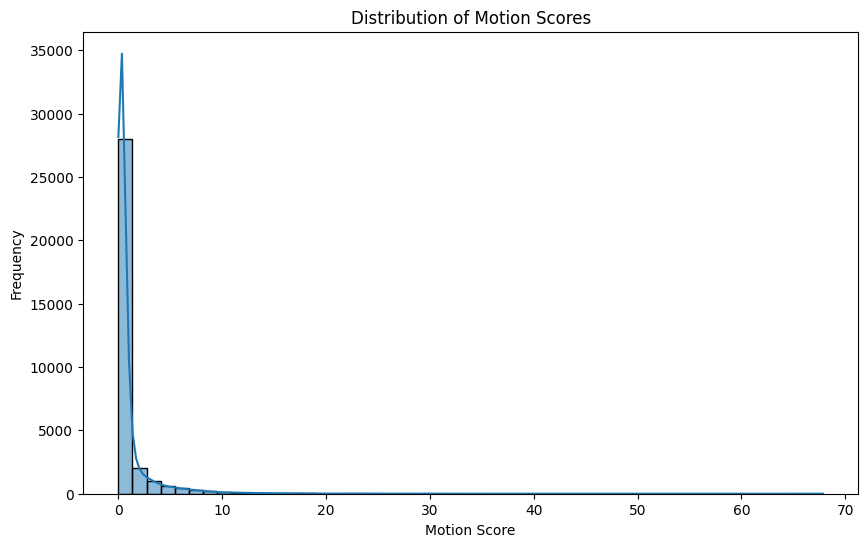


Descriptive statistics for Motion Scores:
count    32967.000000
mean         1.052336
std          2.684836
min          0.006439
25%          0.150739
50%          0.339880
75%          0.745259
max         67.854897
Name: motion_val, dtype: float64


In [14]:
#visualiozation of movement distribution
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.histplot(motion_vals_df['motion_val'].dropna(), bins=50, kde=True)
plt.title('Distribution of Motion Scores')
plt.xlabel('Motion Score')
plt.ylabel('Frequency')
plt.show()


print("\nDescriptive statistics for Motion Scores:")
print(motion_vals_df['motion_val'].describe())

In [15]:
threshold = 0.139 #based on being be around 25th percentile --> can make it less strict and closer towards median
static_frames_df = motion_vals_df[motion_vals_df['motion_val'] <= threshold].copy()
print(static_frames_df.head())
print(static_frames_df.info())

    activity                                         video_file  frame  \
157    Cobra  /content/drive/MyDrive/CS496_Health_Sensing/Ac...    158   
158    Cobra  /content/drive/MyDrive/CS496_Health_Sensing/Ac...    159   
169    Cobra  /content/drive/MyDrive/CS496_Health_Sensing/Ac...    170   
170    Cobra  /content/drive/MyDrive/CS496_Health_Sensing/Ac...    171   
172    Cobra  /content/drive/MyDrive/CS496_Health_Sensing/Ac...    173   

     motion_val  
157    0.133073  
158    0.134929  
169    0.114131  
170    0.092134  
172    0.074176  
<class 'pandas.core.frame.DataFrame'>
Index: 7617 entries, 157 to 33040
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   activity    7617 non-null   object 
 1   video_file  7617 non-null   object 
 2   frame       7617 non-null   int64  
 3   motion_val  7617 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 297.5+ KB
None


In [16]:
cleaned_frames = pd.merge(
    complete_pose_angle_df,
    static_frames_df[['activity', 'video_file', 'frame']],
    on=['activity', 'video_file', 'frame'],
    how='inner'
)

print(cleaned_frames.head())
print(cleaned_frames.info())

output_path = '/content/drive/MyDrive/cleaned_frames.csv'
cleaned_frames.to_csv(output_path, index  = False)

  activity                                         video_file  frame  kp_idx  \
0    Lunge  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      2       0   
1    Lunge  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      2       1   
2    Lunge  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      2       2   
3    Lunge  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      2       3   
4    Lunge  /content/drive/MyDrive/CS496_Health_Sensing/Ac...      2       4   

          x         y         z  visibility  left_elbow_angle  \
0  0.536384  0.247818 -0.064627    0.999816         40.335926   
1  0.538150  0.238143 -0.048693    0.999576         40.335926   
2  0.539738  0.238872 -0.048826    0.999468         40.335926   
3  0.541121  0.239491 -0.048776    0.999628         40.335926   
4  0.533874  0.235420 -0.054264    0.999715         40.335926   

   right_elbow_angle  left_knee_angle  left_hip_angle  right_knee_angle  \
0          52.307459        47.790597        8.653816

In [17]:
#loading it back into
data_training_df = pd.read_csv('/content/drive/MyDrive/cleaned_frames.csv')

In [18]:
from sklearn.model_selection import train_test_split


coordinates_df = data_training_df[['activity', 'video_file', 'frame', 'kp_idx', 'x', 'y', 'z']]
X_kp_data = coordinates_df.pivot_table(
    index = ['activity', 'video_file', 'frame'],
    columns = 'kp_idx',
    values = ['x', 'y', 'z']
)

X_kp_data.columns = [f'{coord}_{idx}' for coord, idx in X_kp_data]
X_kp_data = X_kp_data.reset_index()

X_angle_data = data_training_df[['activity', 'video_file', 'frame', 'left_elbow_angle', 'right_elbow_angle', 'left_knee_angle',
     'right_knee_angle', 'left_hip_angle', 'right_hip_angle']].drop_duplicates(subset = ['activity', 'video_file', 'frame'])


X_kp_angle_combined = pd.merge(X_kp_data, X_angle_data, on = ['activity', 'video_file', 'frame'], how = 'inner')

y = X_kp_angle_combined['activity'] # Corrected: y should be derived from X_kp_angle_combined
X = X_kp_angle_combined.drop(columns = ['activity', 'video_file', 'frame'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [ ]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'X train head: {X_train.head()}')
print(f'y train head: {y_train.head()}')

X_train shape: (3483, 105)
y_train shape: (3483,)
X_test shape: (871, 105)
y_test shape: (871,)
X train head:            x_0       x_1       x_2       x_3       x_4       x_5       x_6  \
2887  0.629434  0.627301  0.626383  0.625380  0.626833  0.625431  0.623782   
2614  0.482769  0.487272  0.489653  0.492358  0.482331  0.481089  0.479674   
420   0.685591  0.683322  0.681443  0.679766  0.683882  0.682303  0.680363   
4132  0.267647  0.256330  0.256758  0.257415  0.254844  0.253687  0.252359   
3178  0.526161  0.527721  0.528688  0.529799  0.524088  0.521379  0.518527   

           x_7       x_8       x_9  ...      z_29      z_30      z_31  \
2887  0.616850  0.614301  0.625285  ...  0.059633 -0.084938  0.022262   
2614  0.502871  0.483232  0.488555  ...  0.367772 -0.070163  0.316505   
420   0.659709  0.659178  0.674256  ... -0.073282  0.206637 -0.156662   
4132  0.260249  0.253727  0.278877  ...  0.195616 -0.010222  0.146719   
3178  0.525533  0.509415  0.524899  ...  0.134753  0.043

Model Training

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = -1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
import joblib
joblib.dump(model, 'yoga_pose_model.pkl')

['yoga_pose_model.pkl']

Model Evaluation

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print(f'classification report: {classification_report(y_test, y_pred)}')

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10, 7))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = model.classes_, yticklabels = model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Accuracy of Model on Irina Data')
plt.show()

NameError: name 'model' is not defined

In [ ]:
df = df[df['activity'] != "Activities"]

Retraining model for own purposes

['activity', 'video_file', 'frame', 'x_0', 'x_1']
Accuracy: 0.9986876640419947


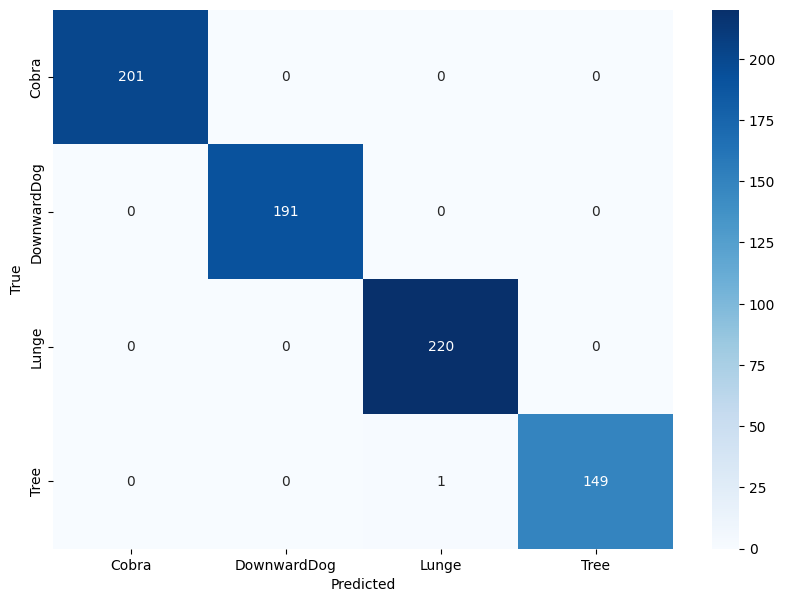

['/content/drive/MyDrive/CS496_Health_Sensing/yoga_pose_model0.pkl']

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

def calculate_angles_from_kp(kp1, kp2, kp3):
  kp1 = np.array(kp1)
  kp2 = np.array(kp2)
  kp3 = np.array(kp3)

  vec1 = kp1 - kp2
  vec2 = kp3 - kp2

  dot = np.dot(vec1, vec2)
  norm1 = np.linalg.norm(vec1)
  norm2 = np.linalg.norm(vec2)

  if norm1 == 0 or norm2 == 0: return 0.0
  cosine_ang = dot / (norm1 * norm2)
  cosine_ang = np.clip(cosine_ang, -1.0, 1.0)
  return np.degrees(np.arccos(cosine_ang))

df = pd.read_csv('/content/drive/MyDrive/cleaned_frames.csv')

if 'kp_idx' in df.columns and 'x' in df.columns:
  df_wide = df.pivot_table(index=['activity', 'video_file', 'frame'], columns='kp_idx', values=['x', 'y', 'z'])

  df_wide.columns = [f'{col[0]}_{col[1]}' for col in df_wide.columns]
  df_wide = df_wide.reset_index()
  df = df_wide
  print(df.columns[:5].tolist())

new_angles = []

for i, row in df.iterrows():
  def get_v(idx):
    return [row[f'x_{idx}'], row[f'y_{idx}'], row[f'z_{idx}']]

  # MP joint indices
  L_SHOULDER, R_SHOULDER = 11, 12
  L_ELBOW, R_ELBOW = 13, 14
  L_WRIST, R_WRIST = 15, 16
  L_HIP, R_HIP = 23, 24
  L_KNEE, R_KNEE = 25, 26
  L_ANKLE, R_ANKLE = 27, 28

  row_angles = {}
  row_angles['left_elbow_angle'] = calculate_angles_from_kp(get_v(L_SHOULDER), get_v(L_ELBOW), get_v(L_WRIST))
  row_angles['right_elbow_angle'] = calculate_angles_from_kp(get_v(R_SHOULDER), get_v(R_ELBOW), get_v(R_WRIST))
  row_angles['left_knee_angle'] = calculate_angles_from_kp(get_v(L_HIP), get_v(L_KNEE), get_v(L_ANKLE))
  row_angles['right_knee_angle'] = calculate_angles_from_kp(get_v(R_HIP), get_v(R_KNEE), get_v(R_ANKLE))
  row_angles['left_hip_angle'] = calculate_angles_from_kp(get_v(L_SHOULDER), get_v(L_HIP), get_v(L_KNEE))
  row_angles['right_hip_angle'] = calculate_angles_from_kp(get_v(R_SHOULDER), get_v(R_HIP), get_v(R_KNEE))
  row_angles['left_shoulder_angle'] = calculate_angles_from_kp(get_v(L_HIP), get_v(L_SHOULDER), get_v(L_ELBOW))
  row_angles['right_shoulder_angle'] = calculate_angles_from_kp(get_v(R_HIP), get_v(R_SHOULDER), get_v(R_ELBOW))

  new_angles.append(row_angles)

# Create a new dataframe w/ only corrected angles
angles_df = pd.DataFrame(new_angles)
angles_df['activity'] = df['activity'] # Add label back in

feature_cols = [
    'left_elbow_angle', 'right_elbow_angle',
    'left_knee_angle', 'right_knee_angle',
    'left_hip_angle', 'right_hip_angle',
    'left_shoulder_angle', 'right_shoulder_angle',
]

X = angles_df[feature_cols]
y = angles_df['activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
acc = model.score(X_test, y_test)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10, 7))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = model.classes_, yticklabels = model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

save_path = '/content/drive/MyDrive/CS496_Health_Sensing/yoga_pose_model0.pkl'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
joblib.dump(model, save_path)

In [ ]:
df.video_file[0]

'/content/drive/MyDrive/CS496_Health_Sensing/Activities/Cobra/cobra_0.MOV'

In [21]:
save_path = '/content/drive/MyDrive/CS496_Health_Sensing/yoga_pose_model_new.pkl'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
joblib.dump(model, save_path)

['/content/drive/MyDrive/CS496_Health_Sensing/yoga_pose_model_new.pkl']

Inference-specific feature extraction (with sliding window)

In [31]:
import cv2
import mediapipe as mp
import numpy as np
import joblib
from collections import deque
import warnings
import os

warnings.filterwarnings("ignore")
# model = joblib.load('/content/drive/MyDrive/CS496_Health_Sensing/Copy of yoga_pose_model.pkl')
model = joblib.load('/content/drive/MyDrive/CS496_Health_Sensing/yoga_pose_model.pkl')


mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

confidence_thresh = 0.65

def calculate_angles_from_kp(kp1, kp2, kp3, offset = 0):
  ## It seems like angles are generally 10-20 deg off or something... so I just added 10
  kp1 = np.array(kp1)
  kp2 = np.array(kp2)
  kp3 = np.array(kp3)
  vec1 = kp1 - kp2
  vec2 = kp3 - kp2
  dot = np.dot(vec1, vec2)
  norm1 = np.linalg.norm(vec1)
  norm2 = np.linalg.norm(vec2)
  if norm1 == 0 or norm2 == 0: return 0.0
  cosine_ang = dot / (norm1 * norm2)
  cosine_ang = np.clip(cosine_ang, -1.0, 1.0)
  angle = np.arccos(cosine_ang)
  d_angle = np.degrees(angle)
  # if d_angle > 160: d_angle += (d_angle - 160) * 0.5
  return d_angle + offset

def extract_features_single_frame(landmarks):
  def get_coords(idx):
    kp = landmarks[idx]
    return [kp.x, kp.y, kp.z]

  L_SHOULDER, R_SHOULDER = 11, 12
  L_ELBOW, R_ELBOW = 13, 14
  L_WRIST, R_WRIST = 15, 16
  L_HIP, R_HIP = 23, 24
  L_KNEE, R_KNEE = 25, 26
  L_ANKLE, R_ANKLE = 27, 28

  angles = {}
  angles['left_elbow_angle'] = calculate_angles_from_kp(get_coords(L_SHOULDER), get_coords(L_ELBOW), get_coords(L_WRIST))
  angles['right_elbow_angle'] = calculate_angles_from_kp(get_coords(R_SHOULDER), get_coords(R_ELBOW), get_coords(R_WRIST))
  angles['left_knee_angle'] = calculate_angles_from_kp(get_coords(L_HIP), get_coords(L_KNEE), get_coords(L_ANKLE))
  angles['right_knee_angle'] = calculate_angles_from_kp(get_coords(R_HIP), get_coords(R_KNEE), get_coords(R_ANKLE))
  angles['left_hip_angle'] = calculate_angles_from_kp(get_coords(L_SHOULDER), get_coords(L_HIP), get_coords(L_KNEE))
  angles['right_hip_angle'] = calculate_angles_from_kp(get_coords(R_SHOULDER), get_coords(R_HIP), get_coords(R_KNEE))
  angles['left_shoulder_angle'] = calculate_angles_from_kp(get_coords(L_HIP), get_coords(L_SHOULDER), get_coords(L_ELBOW))
  angles['right_shoulder_angle'] = calculate_angles_from_kp(get_coords(R_HIP), get_coords(R_SHOULDER), get_coords(R_ELBOW))

  # Limb visibility
  vis = {}
  vis['left_elbow_angle'] = landmarks[L_ELBOW].visibility
  vis['right_elbow_angle'] = landmarks[R_ELBOW].visibility
  vis['left_knee_angle'] = landmarks[L_KNEE].visibility
  vis['right_knee_angle'] = landmarks[R_KNEE].visibility
  vis['left_hip_angle'] = landmarks[L_HIP].visibility
  vis['right_hip_angle'] = landmarks[R_HIP].visibility
  vis['left_shoulder_angle'] = landmarks[L_SHOULDER].visibility
  vis['right_shoulder_angle'] = landmarks[R_SHOULDER].visibility

  angle_features = [
      angles['left_elbow_angle'], angles['right_elbow_angle'],
      angles['left_knee_angle'], angles['right_knee_angle'],
      angles['left_hip_angle'], angles['right_hip_angle'],
      angles['left_shoulder_angle'], angles['right_shoulder_angle']
  ]
  return np.array(angle_features), angles, vis

def reconstruct_angles(feature_vector):
  return {
      'left_elbow_angle': feature_vector[0],
      'right_elbow_angle': feature_vector[1],
      'left_knee_angle': feature_vector[2],
      'right_knee_angle': feature_vector[3],
      'left_hip_angle': feature_vector[4],
      'right_hip_angle': feature_vector[5],
      'left_shoulder_angle': feature_vector[6],
      'right_shoulder_angle': feature_vector[7]
      }

Feedback criteria + actuation

In [36]:
feedback_rules = {
    "Lunge": {
        "front_knee": (75, 110, "Bend front knee to 90°"),
        "back_knee": (160, 185, "Straighten back leg"),
    },
    "Tree": {
        "bent_knee": (30, 85, "Bend knee more"),
        "standing_knee": (160, 185, "Straighten standing leg"),
    },
    "DownwardDog": {
        "legs": (160, 185, "Straighten legs"),
        "back": (40, 110, "Bend hip more"),
        "arms": (140, 185, "Straighten arms"),
        "chest": (135, 195, "Tuck chest in more")
    },
    "Cobra": {
        "back": (90, 145, "Arch back more"),
        "arms": (150, 185, "Straighten arms")
    }
}

def get_feedback(pose_name, angles_dict, vis_dict):

  if pose_name not in feedback_rules: return ""
  rules = feedback_rules[pose_name]

  l_knee = angles_dict['left_knee_angle']
  r_knee = angles_dict['right_knee_angle']
  mapping = {}

  if pose_name == 'Tree':
    if l_knee < r_knee:
      mapping = {'bent_knee':'left_knee_angle', 'standing_knee':'right_knee_angle'}
    else:
      mapping = {'bent_knee':'right_knee_angle', 'standing_knee':'left_knee_angle'}

  elif pose_name == 'Lunge':
    if l_knee < r_knee:
      mapping = {'front_knee':'left_knee_angle', 'back_knee':'right_knee_angle'}
    else:
      mapping = {'front_knee':'right_knee_angle', 'back_knee':'left_knee_angle'}
    # mapping['arms'] = ['left_elbow_angle', 'right_elbow_angle']

  elif pose_name == 'DownwardDog':
    mapping['legs'] = ['left_knee_angle', 'right_knee_angle']
    mapping['back'] = ['left_hip_angle', 'right_hip_angle']
    mapping['arms'] = ['left_elbow_angle', 'right_elbow_angle']
    mapping['chest'] = ['left_shoulder_angle', 'right_shoulder_angle']

  elif pose_name == 'Cobra':
    mapping['back'] = ['left_hip_angle', 'right_hip_angle']
    mapping['arms'] = ['left_elbow_angle', 'right_elbow_angle']

  visual_thresh = 0.8

  for rule_part, (min_v, max_v, msg) in rules.items():
    names = mapping.get(rule_part)
    if not names: continue
    if not isinstance(names, list): names = [names]

    for name in names:
      if vis_dict and vis_dict.get(name, 0) < visual_thresh:
        continue
      val = angles_dict.get(name, 0)
      if val < min_v or val > max_v:
        return msg

  return "Good job!"

def process_video_with_window(video_path, output_path, window_seconds=1.5, target_height=480, rotate=False):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
      print(f"Error opening video file: {video_path}")
      return

    orig_w = int(cap.get(3))
    orig_h = int(cap.get(4))
    fps = int(cap.get(5))

    ################ temp edit for processing speed - idk I think it works faster at 480p ######################
    # scale_ratio = target_height / float(orig_h)
    # new_height = target_height
    # new_width = int(orig_w * scale_ratio)
    new_height = orig_h
    new_width = orig_w  #jk too lazy to fix the other variables
    ############################################################################################################


    #idk why but for whatever reason avi and MJPG works better
    if not output_path.endswith('.avi'):
      output_path = output_path.rsplit('.', 1)[0] + '.avi'
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'MJPG'), fps, (new_width, new_height))

    buffer_size = int(fps * window_seconds)
    feature_buffer = deque(maxlen=buffer_size)
    vis_buffer = deque(maxlen=buffer_size)

    print(f"Processing w/ confidence threshold at {confidence_thresh*100}%...")

    try:
      while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
          break

        frame = cv2.resize(frame, (new_width, new_height))
        if rotate:
          frame = cv2.rotate(frame, cv2.ROTATE_180)

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(image)

        pose_text = "Buffering..."
        feedback_text = ""
        debug_angles = {}
        confidence = 0.0

        if results.pose_world_landmarks:
          if results.pose_landmarks:
            mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
          raw_vec, angles, vis = extract_features_single_frame(results.pose_world_landmarks.landmark)

          feature_buffer.append(raw_vec)
          vis_buffer.append(vis)

          if len(feature_buffer) == buffer_size:
            avg_vec = np.mean(feature_buffer, axis=0)

            probabilities = model.predict_proba(avg_vec.reshape(1, -1))[0]
            confidence = np.max(probabilities)
            pred_idx = np.argmax(probabilities)
            pred_label = model.classes_[pred_idx]

            if confidence > confidence_thresh:
              pose_text = f"{pred_label} ({int(confidence*100)}%)"

              # visual confidence for limbs hidden from camera
              avg_vis = {}
              for key in vis:
                avg_vis[key] = np.mean([v[key] for v in vis_buffer])
              avg_angles_dict = reconstruct_angles(avg_vec)

              feedback_text = get_feedback(pred_label, avg_angles_dict, avg_vis)

              # Angles on display for debugging
              debug_angles = avg_angles_dict
            else:
              pose_text = "Waiting..."
              feedback_text = "Please hold a pose"
          else:
            pose_text = f"Buffering..."

        # UI Drawing
        cv2.rectangle(frame, (0,0), (new_width, 100), (0,0,0), -1)

        status_color = (255, 255, 255)
        if pose_text == "Waiting...": status_color = (192, 192, 192)

        cv2.putText(frame, f"Pose: {pose_text}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, status_color, 2)

        color = (0, 255, 0) if "Good" in feedback_text else (0, 0, 255)
        cv2.putText(frame, f"{feedback_text}", (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        if debug_angles and pose_text != "Waiting...":
          y_offset = 150
          relevant_keys = []

          if pred_label == 'Cobra':
            relevant_keys = ['left_hip_angle', 'right_hip_angle', 'left_elbow_angle', 'right_elbow_angle']
          elif pred_label == 'Tree':
            relevant_keys = ['left_knee_angle', 'right_knee_angle']
          elif pred_label == 'Lunge':
            relevant_keys = ['left_knee_angle', 'right_knee_angle']
          elif pred_label == 'DownwardDog':
            relevant_keys = ['left_hip_angle', 'right_hip_angle', 'left_knee_angle', 'right_knee_angle',
                             'left_elbow_angle', 'right_elbow_angle', 'left_shoulder_angle', 'right_shoulder_angle']

          for key in relevant_keys:
            val = debug_angles.get(key, 0)
            vis_score = avg_vis.get(key, 0)
            if vis_score < .7:
              text_color = (128,128,128)
            else:
              text_color = (255,255,0)
            cv2.putText(frame, f"{key}: {int(val)} (v:{vis_score:.2f})",(20, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 2)
            y_offset += 30
        out.write(frame)

    except Exception as e:
      print(f"Error: {e}")
    finally:
      cap.release()
      out.release()
      print("Done processing.")

In [35]:
process_video_with_window('/content/drive/MyDrive/CS496_Health_Sensing/Activities/Lunge/lunge_12.mp4', 'output_confident04.avi')


Processing w/ confidence threshold at 65.0%...
Done processing.


### UPDATED

In [40]:
import cv2
import mediapipe as mp
import numpy as np
import joblib
from collections import deque
import warnings
import os

warnings.filterwarnings("ignore")
model = joblib.load('/content/drive/MyDrive/CS496_Health_Sensing/yoga_pose_model.pkl')

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    model_complexity=1,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

CONFIDENCE_THRESHOLD = 0.65
SKELETON_QUALITY_THRESH = 0.85
VISIBILITY_THRESH = 0.65

def calculate_angles_from_kp(kp1, kp2, kp3):
    kp1 = np.array(kp1)
    kp2 = np.array(kp2)
    kp3 = np.array(kp3)

    vec1 = kp1 - kp2
    vec2 = kp3 - kp2

    dot = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)

    if norm1 == 0 or norm2 == 0: return 0.0

    cosine_ang = dot / (norm1 * norm2)
    cosine_ang = np.clip(cosine_ang, -1.0, 1.0)
    angle = np.arccos(cosine_ang)
    d_angle = np.degrees(angle)

    return d_angle

def extract_features_single_frame(landmarks):
    def get_coords(idx):
        kp = landmarks[idx]
        return [kp.x, kp.y, kp.z]

    L_SHOULDER, R_SHOULDER = 11, 12
    L_ELBOW, R_ELBOW = 13, 14
    L_WRIST, R_WRIST = 15, 16
    L_HIP, R_HIP = 23, 24
    L_KNEE, R_KNEE = 25, 26
    L_ANKLE, R_ANKLE = 27, 28

    angles = {}
    angles['left_elbow_angle'] = calculate_angles_from_kp(get_coords(L_SHOULDER), get_coords(L_ELBOW), get_coords(L_WRIST))
    angles['right_elbow_angle'] = calculate_angles_from_kp(get_coords(R_SHOULDER), get_coords(R_ELBOW), get_coords(R_WRIST))
    angles['left_knee_angle'] = calculate_angles_from_kp(get_coords(L_HIP), get_coords(L_KNEE), get_coords(L_ANKLE))
    angles['right_knee_angle'] = calculate_angles_from_kp(get_coords(R_HIP), get_coords(R_KNEE), get_coords(R_ANKLE))
    angles['left_hip_angle'] = calculate_angles_from_kp(get_coords(L_SHOULDER), get_coords(L_HIP), get_coords(L_KNEE))
    angles['right_hip_angle'] = calculate_angles_from_kp(get_coords(R_SHOULDER), get_coords(R_HIP), get_coords(R_KNEE))
    angles['left_shoulder_angle'] = calculate_angles_from_kp(get_coords(L_HIP), get_coords(L_SHOULDER), get_coords(L_ELBOW))
    angles['right_shoulder_angle'] = calculate_angles_from_kp(get_coords(R_HIP), get_coords(R_SHOULDER), get_coords(R_ELBOW))

    vis = {}
    vis['left_elbow_angle'] = landmarks[L_ELBOW].visibility
    vis['right_elbow_angle'] = landmarks[R_ELBOW].visibility
    vis['left_knee_angle'] = landmarks[L_KNEE].visibility
    vis['right_knee_angle'] = landmarks[R_KNEE].visibility
    vis['left_hip_angle'] = landmarks[L_HIP].visibility
    vis['right_hip_angle'] = landmarks[R_HIP].visibility
    vis['left_shoulder_angle'] = landmarks[L_SHOULDER].visibility
    vis['right_shoulder_angle'] = landmarks[R_SHOULDER].visibility

    #  Calculate Overall "Skeleton Quality"
    # (Average visibility of the core joints: Shoulders, Hips, Knees)
    core_joints = [L_SHOULDER, R_SHOULDER, L_HIP, R_HIP, L_KNEE, R_KNEE]
    skeleton_quality = np.mean([landmarks[i].visibility for i in core_joints])

    angle_features = [
        angles['left_elbow_angle'], angles['right_elbow_angle'],
        angles['left_knee_angle'], angles['right_knee_angle'],
        angles['left_hip_angle'], angles['right_hip_angle'],
        angles['left_shoulder_angle'], angles['right_shoulder_angle']
    ]

    return np.array(angle_features), angles, vis, skeleton_quality

def reconstruct_angles(feature_vector):
    return {
        'left_elbow_angle': feature_vector[0],
        'right_elbow_angle': feature_vector[1],
        'left_knee_angle': feature_vector[2],
        'right_knee_angle': feature_vector[3],
        'left_hip_angle': feature_vector[4],
        'right_hip_angle': feature_vector[5],
        'left_shoulder_angle': feature_vector[6],
        'right_shoulder_angle': feature_vector[7]
    }

feedback_rules = {
    "Lunge": {
        "front_knee": (75, 115, "Bend front knee to 90°"),
        "back_knee": (150, 185, "Straighten back leg")
    },
    "Tree": {
        "bent_knee": (25, 100, "Bend knee more"),
        "standing_knee": (160, 185, "Straighten standing leg")
    },
    "DownwardDog": {
        "legs": (160, 185, "Straighten legs"),
        "back": (40, 110, "Bend hip more (V shape)"),
        "arms": (150, 185, "Straighten arms"),
        "chest": (135, 195, "Tuck chest in more")
    },
    "Cobra": {
        "back": (90, 160, "Arch back more"),
        "arms": (140, 185, "Straighten arms")
    }
}

def get_feedback(pose_name, angles_dict, vis_dict):
    if pose_name not in feedback_rules: return ""
    rules = feedback_rules[pose_name]

    l_knee = angles_dict['left_knee_angle']
    r_knee = angles_dict['right_knee_angle']
    mapping = {}

    if pose_name == 'Tree':
        if l_knee < r_knee: mapping = {'bent_knee':'left_knee_angle', 'standing_knee':'right_knee_angle'}
        else: mapping = {'bent_knee':'right_knee_angle', 'standing_knee':'left_knee_angle'}
    elif pose_name == 'Lunge':
        if l_knee < r_knee: mapping = {'front_knee':'left_knee_angle', 'back_knee':'right_knee_angle'}
        else: mapping = {'front_knee':'right_knee_angle', 'back_knee':'left_knee_angle'}
        mapping['arms'] = ['left_elbow_angle', 'right_elbow_angle']
    elif pose_name == 'DownwardDog':
        mapping['legs'] = ['left_knee_angle', 'right_knee_angle']
        mapping['back'] = ['left_hip_angle', 'right_hip_angle']
        mapping['arms'] = ['left_elbow_angle', 'right_elbow_angle']
        mapping['chest'] = ['left_shoulder_angle', 'right_shoulder_angle']
    elif pose_name == 'Cobra':
        mapping['back'] = ['left_hip_angle', 'right_hip_angle']
        mapping['arms'] = ['left_elbow_angle', 'right_elbow_angle']

    for rule_part, (min_v, max_v, msg) in rules.items():
        names = mapping.get(rule_part)
        if not names: continue
        if not isinstance(names, list): names = [names]

        for name in names:
            # CHECK VISIBILITY FIRST
            if vis_dict and vis_dict.get(name, 0) < VISIBILITY_THRESH: continue

            val = angles_dict.get(name, 0)
            if val < min_v or val > max_v: return msg

    return "Good job!"

def process_video_with_window(video_path, output_path, window_seconds=1.5, target_height=480, rotate=False):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return

    orig_w = int(cap.get(3))
    orig_h = int(cap.get(4))
    fps = int(cap.get(5))

    scale_ratio = target_height / float(orig_h)
    new_height = target_height
    new_width = int(orig_w * scale_ratio)

    if not output_path.endswith('.avi'): output_path = output_path.rsplit('.', 1)[0] + '.avi'
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'MJPG'), fps, (new_width, new_height))

    buffer_size = int(fps * window_seconds)
    feature_buffer = deque(maxlen=buffer_size)
    vis_buffer = deque(maxlen=buffer_size)

    print(f"Processing... (Thresholds: Conf={CONFIDENCE_THRESHOLD}, SkelQuality={SKELETON_QUALITY_THRESH})")

    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret: break

            frame = cv2.resize(frame, (new_width, new_height))

            if rotate:
                frame = cv2.rotate(frame, cv2.ROTATE_180)

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(image)

            pose_text = "Scanning..."
            feedback_text = ""
            debug_angles = {}
            avg_vis = {}

            if results.pose_world_landmarks:

                if results.pose_landmarks:
                    mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

                raw_vec, angles, vis, skel_quality = extract_features_single_frame(results.pose_world_landmarks.landmark)

                if skel_quality < SKELETON_QUALITY_THRESH:
                    feature_buffer.clear()
                    vis_buffer.clear()
                    pose_text = "Adjust Camera..."
                    feedback_text = "Ensure full body is visible"

                else:
                    feature_buffer.append(raw_vec)
                    vis_buffer.append(vis)

                    if len(feature_buffer) == buffer_size:
                        avg_vec = np.mean(feature_buffer, axis=0)

                        probabilities = model.predict_proba(avg_vec.reshape(1, -1))[0]
                        confidence = np.max(probabilities)
                        pred_idx = np.argmax(probabilities)
                        pred_label = model.classes_[pred_idx]

                        if confidence > CONFIDENCE_THRESHOLD:
                            pose_text = f"{pred_label} ({int(confidence*100)}%)"

                            for key in vis:
                                avg_vis[key] = np.mean([v[key] for v in vis_buffer])

                            avg_angles_dict = reconstruct_angles(avg_vec)
                            feedback_text = get_feedback(pred_label, avg_angles_dict, avg_vis)

                            debug_angles = avg_angles_dict
                        else:
                            pose_text = "Unknown Pose"
                            feedback_text = "Hold a yoga pose..."
                    else:
                        pose_text = "Analyzing..."

            cv2.rectangle(frame, (0,0), (new_width, 100), (0,0,0), -1)

            status_color = (255, 255, 255)
            if "Adjust" in pose_text or "Unknown" in pose_text: status_color = (192, 192, 192)

            cv2.putText(frame, f"Pose: {pose_text}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, status_color, 2)

            fb_color = (0, 255, 0) if "Good" in feedback_text else (0, 0, 255)
            cv2.putText(frame, f"{feedback_text}", (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.6, fb_color, 2)

            if debug_angles and "Unknown" not in pose_text:
                y_offset = 150
                relevant_keys = []

                if pred_label == 'Cobra':
                    relevant_keys = ['left_hip_angle', 'right_hip_angle', 'left_elbow_angle', 'right_elbow_angle']
                elif pred_label == 'Tree':
                    relevant_keys = ['left_knee_angle', 'right_knee_angle']
                elif pred_label == 'Lunge':
                    relevant_keys = ['left_knee_angle', 'right_knee_angle']
                elif pred_label == 'DownwardDog':
                    relevant_keys = ['left_hip_angle', 'right_hip_angle', 'left_knee_angle', 'right_knee_angle']

                for key in relevant_keys:
                    val = debug_angles.get(key, 0)
                    v_score = avg_vis.get(key, 0)

                    text_color = (255, 255, 0) if v_score >= VISIBILITY_THRESH else (128, 128, 128)

                    cv2.putText(frame, f"{key}: {int(val)} (v:{v_score:.2f})",
                                (20, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 2)
                    y_offset += 30

            out.write(frame)

    except Exception as e:
        print(f"Error: {e}")
    finally:
        cap.release()
        out.release()
        print("Done processing.")

# --- RUN IT ---
# process_video_with_window('/content/video.mp4', 'output_final.avi')

In [41]:
process_video_with_window('/content/drive/MyDrive/CS496_Health_Sensing/Poses/dDog_val_0.MOV', 'output_confident05.avi')


Processing... (Thresholds: Conf=0.65, SkelQuality=0.85)
Done processing.


In [42]:
process_video_with_window('/content/drive/MyDrive/CS496_Health_Sensing/Activities/Lunge/lunge_13.mp4', 'output_confident06.avi')

Processing... (Thresholds: Conf=0.65, SkelQuality=0.85)
Done processing.


In [ ]:
#shit don't work

# from IPython.display import HTML
# from base64 import b64encode
# import os

# def show_video(video_path, width=640):
#     if not os.path.exists(video_path):
#         print(f"Error: Video file not found at {video_path}")
#         return

#     mp4 = open(video_path,'rb').read()
#     data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

#     return HTML(f"""
#     <video width={width} controls>
#           <source src="{data_url}" type="video/mp4">
#     </video>
#     """)
# show_video('output_smoothed.MOV')